#Imports

In [16]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from matplotlib.image import imread
from scipy.optimize import brentq
from skimage.transform import rescale, resize
!pip install -U --no-cache-dir gdown --pre
!pip install -q tensorflow_datasets
import tensorflow_datasets as tfds
import pathlib, zipfile, tqdm
import random
from random import sample
from PIL import Image
from torch.utils.data import Subset

#Globals

In [27]:
LOCAL_PATH = "/content/dataset"

In [3]:
# Select the best available device (CPU, CUDA, or MPS (Metal Performance Shaders for macOS))
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")
DEVICE = device

Using CUDA device: Tesla T4


#Utils

In [4]:
# -------------------------
# Visualization
# -------------------------

def visualize_sample(dataset, index=4):
    image, mask = dataset[index]
    print("----------------------------------")
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

    for i, group_name in enumerate(GROUP_NAMES):
        pixel_count = mask[i].sum().item()
        total_pixels = mask[i].numel()
        percentage = (pixel_count / total_pixels) * 100
        print(f"{group_name}: {pixel_count:.0f} pixels ({percentage:.2f}%)")
    print("----------------------------------")
    visualize_multilabel_mask(image, mask)

def visualize_multilabel_mask(image, multilabel_mask, save_path=None):
    COLORS = plt.cm.tab10.colors
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(8):
        mask = multilabel_mask[i].cpu().numpy()
        overlay = np.zeros_like(img_np)
        color = COLORS[i % len(COLORS)]
        for c in range(3):
            overlay[..., c] = mask * color[c]
        blended = 0.5 * img_np + 0.5 * overlay
        axes[i + 1].imshow(blended)
        axes[i + 1].set_title(f'{GROUP_NAMES[i]} (sum={mask.sum():.0f})')
        axes[i + 1].axis('off')

    if len(axes) > 8:
        axes[8].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [5]:
def load_weights(model, path):
    if not os.path.exists(path):
        print("No model weights found at:", path)
        return model # Return the original model if no weights are found
    # Load the state dictionary directly from the file
    state_dict = torch.load(path)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded model weights from {path}")
    return model

In [22]:
def unzip(zip_path, dest):
    zip_path = pathlib.Path(zip_path)
    dest = pathlib.Path(dest)
    print(f"Extracting {zip_path.name} ...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get the list of files in the zip for the progress bar
        file_list = z.namelist()
        # Use tqdm to wrap the iteration over the file list
        for file in tqdm.tqdm(file_list, desc=f"Extracting {zip_path.name}", unit="file"):
            # Extract each file individually
            z.extract(file, dest)
    print("done!")

#Dataset Lost and Found

In [7]:
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1U-Poh7gkgrZ_L1fLfrWjft8GfbRB0HMV -O dataset

Retrieving folder contents
Processing file 1ynZc4r_u8OXI1b1PP_0953u4fMGse8WB rightImg8bit.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1ynZc4r_u8OXI1b1PP_0953u4fMGse8WB
From (redirected): https://drive.google.com/uc?id=1ynZc4r_u8OXI1b1PP_0953u4fMGse8WB&confirm=t&uuid=3bfa88a4-8f64-4036-a044-6dbb4ae3c1e3
To: /content/dataset/rightImg8bit.zip
100% 5.79G/5.79G [01:39<00:00, 58.0MB/s]
Download completed


In [23]:
#@title Unzip dataset

#Unzip weights and put them in a list
zippath = pathlib.Path('/content/dataset/rightImg8bit.zip')
DEST_W_PATH = pathlib.Path("/content/dataset/lostandfound")
unzip(zippath, DEST_W_PATH)
# zippath.unlink()  #delete zip file
print("ZIP files extracted and deleted")

Extracting rightImg8bit.zip ...


Extracting rightImg8bit.zip: 100%|██████████| 2255/2255 [01:13<00:00, 30.66file/s]

done!
ZIP files extracted and deleted


In [17]:
ID_TO_TRAINID = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,  # void classes
    7: 0, 8: 1, 9: 255, 10: 255,                             # road, sidewalk, parking, rail
    11: 2, 12: 3, 13: 4, 14: 255, 15: 255, 16: 255,          # construction
    17: 5, 18: 255, 19: 6, 20: 7,                            # object
    21: 8, 22: 9, 23: 10,                                    # background
    24: 11, 25: 12,                                          # human
    26: 13, 27: 14, 28: 15, 29: 255, 30: 255,                # vehicles
    31: 16, 32: 17, 33: 18                                   # train, motorcycle, bicycle
}
def convert_id_to_trainId(pil_img):
    id_mask = np.array(pil_img, dtype=np.uint8)
    train_id_mask = np.full_like(id_mask, 255)  # default to ignore

    for id_val, train_id_val in ID_TO_TRAINID.items():
        train_id_mask[id_mask == id_val] = train_id_val

    return train_id_mask

# -------------------------
# Cityscapes 19 -> 7 Groups Mapping
# Based on trainId values (NOT id!)
# -------------------------

CITYSCAPES_GROUPS = {
    'road': [0],                              # road
    'flat_nonroad': [1],                      # sidewalk
    'construction': [2, 3, 4],                # building, wall, fence
    'object': [5, 6, 7],                      # pole, traffic light, traffic sign
    'background': [8, 9, 10],                 # vegetation, terrain, sky
    'human': [11, 12],                        # person, rider
    'vehicle': list(range(13, 19)),           # car to bicycle
}

GROUP_NAMES = ['Road', 'Flat(non-road)', 'Construction', 'Object', 'Background', 'Human', 'Vehicle', 'Objectness']

CLASS_TO_GROUP = {}
for group_idx, (_, train_ids) in enumerate(CITYSCAPES_GROUPS.items()):
    for tid in train_ids:
        CLASS_TO_GROUP[tid] = group_idx

NUM_GROUPS = 7  # Last group (index 7) = Objectness

# -------------------------
# Label Conversion Function
# -------------------------

def convert_mask_to_multilabel(pil_img):
    mask_np = np.array(pil_img, dtype=np.uint8)  # trainId mask
    H, W = mask_np.shape
    label_tensor = np.zeros((NUM_GROUPS + 1, H, W), dtype=np.float32)

    for train_id, group_idx in CLASS_TO_GROUP.items():
        mask = (mask_np == train_id)
        label_tensor[group_idx][mask] = 1.0

        # Objectness: groups 2, 3, 5, 6 (Construction, Object, Human, Vehicle)
        if group_idx in [2, 3, 5, 6]:
            label_tensor[NUM_GROUPS][mask] = 1.0

    return torch.from_numpy(label_tensor)

In [18]:
# -------------------------
# Transforms and Dataset
# -------------------------

img_tf = transforms.ToTensor()
lbl_tf = transforms.Lambda(lambda img: convert_mask_to_multilabel(Image.fromarray(convert_id_to_trainId(img))))

#Model Definition

In [9]:
class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Load pretrained DeepLabV3 and remove the classifier
        backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]  # ASPP module
        # Custom sigmoid head
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Conv2d(256, num_classes + 1, kernel_size=1),
                                        # nn.Sigmoid() # RIGHT NOW IT IS COMMENTED AS WE WILL TRAIN USING torch.nn.BCEWithLogitsLoss
                                        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        # Extract features
        features = self.backbone_features(x)
        # Apply ASPP
        x = self.aspp(features['out'])
        # Apply classifier with sigmoid
        x = self.classifier(x)
        # Upsample to input resolution
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

In [10]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"
"""

LEARNING_RATE = 0.01
EPOCHS = 8
BATCH_SIZE = 3
model = DeepLabV3_SigmoidHead(num_classes=7)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 99.7MB/s]


In [30]:
# ready-made dataset wrapper
val_set = Cityscapes(
    root=LOCAL_PATH,
    split = 'val',            # 500 fine labelled images
    mode='fine',              # using the accurate (not coarse) masks
    target_type ='semantic',  # we want a single channel with class-IDs
    transform=img_tf,         # apply to the RGB image
    target_transform=lbl_tf   # apply to the mask
)

print(f"Validation set size: {len(val_set)}")
print(f"Validation set item shape: {val_set[0][1].shape}")
visualize_sample(val_set, index=random.randint(0, len(val_set)))

RuntimeError: Dataset not found or incomplete. Please make sure all required folders for the specified "split" and "mode" are inside the "root" directory

In [ ]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)
# ====== Create a small validation subset loader ======
VAL_SUBSET_BATCHES = 10
BATCH_SIZE = int(val_loader.batch_size)
TOTAL_VAL_SAMPLES = VAL_SUBSET_BATCHES * BATCH_SIZE

val_indices = sample(range(len(val_set)), TOTAL_VAL_SAMPLES)
val_subset = Subset(val_set, val_indices)

val_subset_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [ ]:
#@title  Download Weight Checkpoints
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1X_sie38bSouwjZVhEQQuzjMd5YJ0Lht9 -O dataset

In [ ]:
#@title Load Model's weights

#Unzip weights and put them in a list
zippath = pathlib.Path('/content/dataset/model_weights.zip')
DEST_W_PATH = pathlib.Path("/content/dataset/weights")
unzip(zippath, DEST_W_PATH)
# zippath.unlink()  #delete zip file
print("ZIP files extracted and deleted")


Extracting model_weights.zip ...


Extracting model_weights.zip: 100%|██████████| 26/26 [00:15<00:00,  1.63file/s]

done!
ZIP files extracted and deleted


In [ ]:
#Load weights to model
folder_path = '/content/dataset/weights'
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# # Sort the file_list
sorted_file_list = sorted(file_list)
avg_loss_list = []
accuracy_list = []
for item_name in sorted_file_list:
  if item_name == "last_checkpoint.pth":
    pass
  else:
    item_path = os.path.join(folder_path, item_name)
    model.to(DEVICE)
    model_loaded = load_weights(model,item_path)
    #Evaluate model using original val_loader
    # avg_loss, accuracy = evaluate_model(model_loaded, val_loader, loss_fn,training = False)
    # print(f"Epoch: {item_name}, Average Loss: {avg_loss}, Accuracy: {accuracy}")
    # file_list.append(item_name)
    # avg_loss_list.append(avg_loss)
    # accuracy_list.append(accuracy)

#Unkown Object Scores

In [15]:
# Pick a random index from the val set
idx = random.randint(0, len(val_set) - 1)
image, true_mask = val_set[idx]  # image: [3,H,W], true_mask: [8,H,W]



# Move image to batch form and to GPU
model.eval()
model.to(DEVICE)
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1,3,H,W]

    output = model(input_tensor)                 # [1,8,H,W]
    pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [8,H,W]

    known_class_probs = pred_mask[:7,:,:] # Shape: [7, H, W]
    inv_known_class_probs = 1 - known_class_probs
    inv_probs_product = torch.prod(inv_known_class_probs, dim=0) # Shape: [H, W]
    objectness_scores = pred_mask[7,:,:] # Shape: [H, W]

    unk_obj_score = inv_probs_product * objectness_scores # Shape: [H, W]
    print(unk_obj_score[1][1])

NameError: name 'val_set' is not defined

#fn CONTROL

In [12]:
# Load cached data
if not os.path.exists('../data'):
    os.system('gdown 1h7S6N_Rx7gdfO3ZunzErZy6H7620EbZK -O ../data.tar.gz')
    os.system('tar -xf ../data.tar.gz -C ../')
    os.system('rm ../data.tar.gz')

data = np.load('../data/polyps/polyps-pranet.npz')
example_paths = os.listdir('../data/polyps/examples')

sgmd = data['sgmd'] # sigmoid scores
gt_masks = data['targets']
example_indexes = data['example_indexes']

In [14]:
print("sgmd shape:", sgmd.shape)
print("gt_masks shape:", gt_masks.shape)
print("uos:",unk_obj_score.shape)


sgmd shape: (1798, 352, 352)
gt_masks shape: (1798, 352, 352)


NameError: name 'unk_obj_score' is not defined

In [ ]:
# Problem setup
n=500 # number of calibration points
alpha = 0.1 # 1-alpha is the desired false negative rate

def false_negative_rate(pred_masks, true_masks):
    return 1-((pred_masks * true_masks).sum(axis=1).sum(axis=1)/true_masks.sum(axis=1).sum(axis=1)).mean()

In [ ]:
# Split the softmax scores into calibration and validation sets (save the shuffling)
idx = np.array([1] * n + [0] * (sgmd.shape[0]-n)) > 0
np.random.shuffle(idx)
cal_sgmd, val_sgmd = sgmd[idx,:], sgmd[~idx,:]
cal_gt_masks, val_gt_masks = gt_masks[idx], gt_masks[~idx]

### Conformal risk control happens here

In [ ]:
# Run the conformal risk control procedure
def lamhat_threshold(lam): return false_negative_rate(cal_sgmd>=lam, cal_gt_masks) - ((n+1)/n*alpha - 1/n)
lamhat = brentq(lamhat_threshold, 0, 1)
predicted_masks = val_sgmd >= lamhat

In [ ]:
# Calculate empirical FNR
print(f"The empirical FNR is: {false_negative_rate(predicted_masks, val_gt_masks)} and the threshold value is: {lamhat}")

The empirical FNR is: 0.09701384782974165 and the threshold value is: 0.43368619680439285


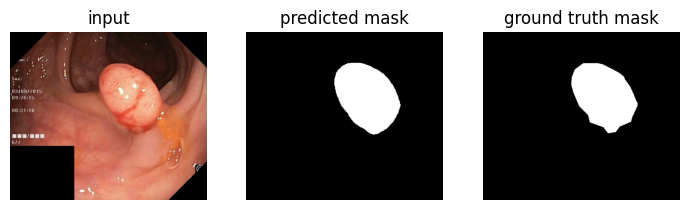

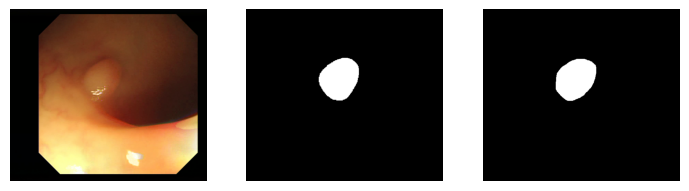

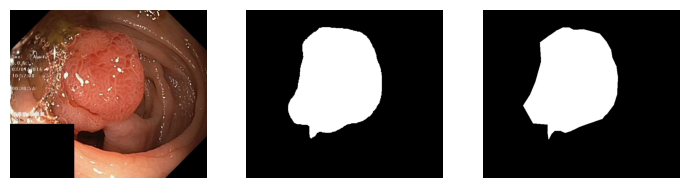

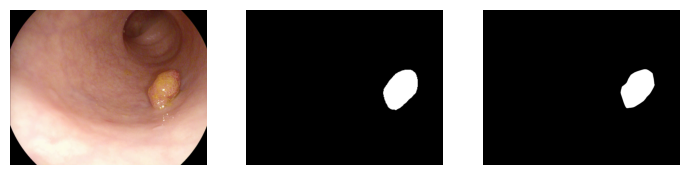

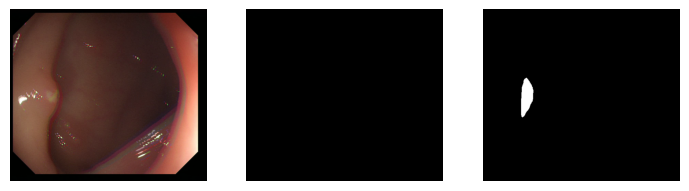

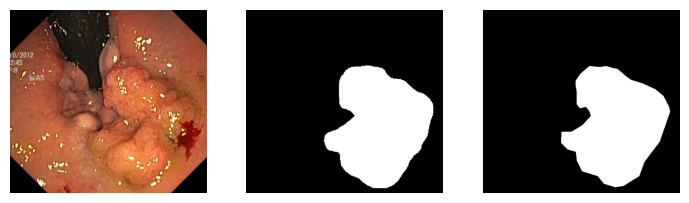

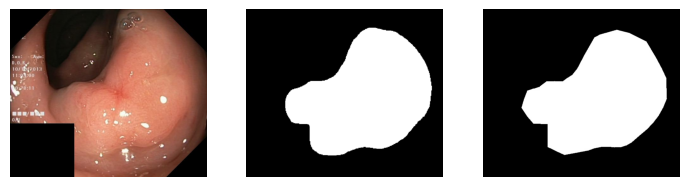

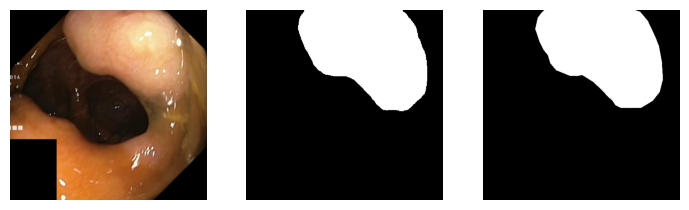

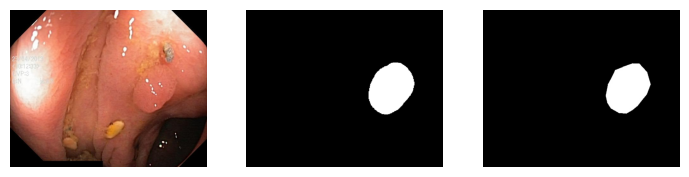

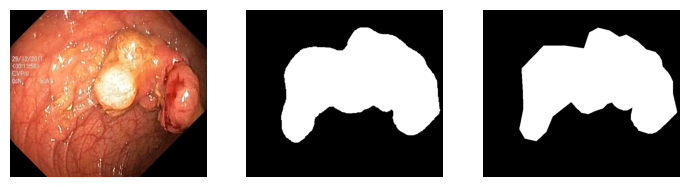

In [ ]:
# Show some examples
for i in range(10):
    rand_idx = np.random.choice(example_indexes)
    img = imread('../data/polyps/examples/' + str(rand_idx) + '.jpg')
    gt_mask = imread('../data/polyps/examples/' + str(rand_idx) + '_gt_mask.jpg')
    predicted_mask = resize(sgmd[rand_idx] > lamhat, (img.shape[0],img.shape[1]), anti_aliasing=False)
    fig, axs = plt.subplots(1,3,figsize=(8.64,4.76))
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[1].imshow(predicted_mask, cmap='gray')
    axs[1].axis('off')
    axs[2].imshow(gt_mask, cmap='gray')
    axs[2].axis('off')
    if i == 0:
        axs[0].set_title('input')
        axs[1].set_title('predicted mask')
        axs[2].set_title('ground truth mask')
    plt.show()

This method was first introduced here: https://arxiv.org/abs/2208.02814.